<a href="https://colab.research.google.com/github/s-bhatia1216/esteelauder1b/blob/initial-bandwidth-analysis/Initial_Bandwidth_Selection_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *Initial Bandwidth Selection Analysis*
Exploring the impact of bandwidth on treatment effect estimates.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_excel('/content/drive/My Drive/CustomerDataset.xlsx')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_excel('Customer Purchase DataSet.xlsx')

In [ ]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Add binary boolean treatment indictor at $80
df['Treatment'] = (df['Dollars Spent 2021'] >= 80).astype(int)

# Define independent and dependent variables according to initial model specifications
df['Interaction'] = df['Dollars Spent 2021'] * df['Treatment']
X = df[['Dollars Spent 2021', 'Treatment', 'Interaction']]
X = sm.add_constant(X)
y = df['Dollars Spent 2022']


model = sm.OLS(df['Dollars Spent 2022'], X).fit()

In [ ]:
from scipy.stats import levene

# List to store treatment effects, confidence intervals, P-value of Levene tests, and data set sizes
treatment_effects = []
ci_lower = []
ci_upper = []
levene_pvalues = []
data_size = []

# Range of bandwidths covered
start = 5
end = 175
inc = 1

# Loop to test badwidths. start -> end in inc intervals
for bandwidth in range(start, end, inc):

  # Filter 2021 spending data based on current bandwidth
  filtered_df = df[(df['Dollars Spent 2021'] >= 80 - bandwidth) & (df['Dollars Spent 2021'] <= 80 + bandwidth)]

  filtered_df.loc[:, 'Interaction'] = filtered_df['Dollars Spent 2021'] * filtered_df['Treatment']
  X = filtered_df[['Dollars Spent 2021', 'Treatment', 'Interaction']]
  X = sm.add_constant(X)
  y = filtered_df['Dollars Spent 2022']

  # Fit the model with data selection
  model = sm.OLS(y, X).fit()


  # Extract model treatment effect and append to list
  treatment_effects.append(model.params['Treatment'])

  # Extract confidence intervals and append to list
  conf_int = model.conf_int().loc['Treatment']
  ci_lower.append(conf_int[0])
  ci_upper.append(conf_int[1])

  # Extract residuals split into treated and untreated
  residuals = model.resid
  treated_residuals = residuals[filtered_df['Treatment'] == 1]
  untreated_residuals = residuals[filtered_df['Treatment'] == 0]
  # Extract P-value of Levene tests and append to list
  p_value = levene(treated_residuals, untreated_residuals)[1]
  levene_pvalues.append(p_value)

  # Extract data set size and append to list
  data_size.append(filtered_df.size)


# Convert the results to a DataFrame for easy plotting
results_df = pd.DataFrame({
    'Bandwidth': range(start, end, inc),
    'Treatment_Effect': treatment_effects,
    'CI_Lower': ci_lower,
    'CI_Upper': ci_upper,
    'Levene_P-Values': levene_pvalues,
    'Data_Size': data_size
})
results_df.head()

,Bandwidth,Treatment_Effect,CI_Lower,CI_Upper,Levene_P-Values,Data_Size
0,5,10.478956,-60.939216,81.897127,0.140657,4490
1,6,13.830445,-41.018682,68.679572,0.165060,5405
2,7,17.240848,-25.786377,60.268074,0.300654,6365
3,8,4.562582,-31.152452,40.277616,0.633174,7295
4,9,11.184226,-18.979972,41.348425,0.481605,8190


## Complete Range Analysis

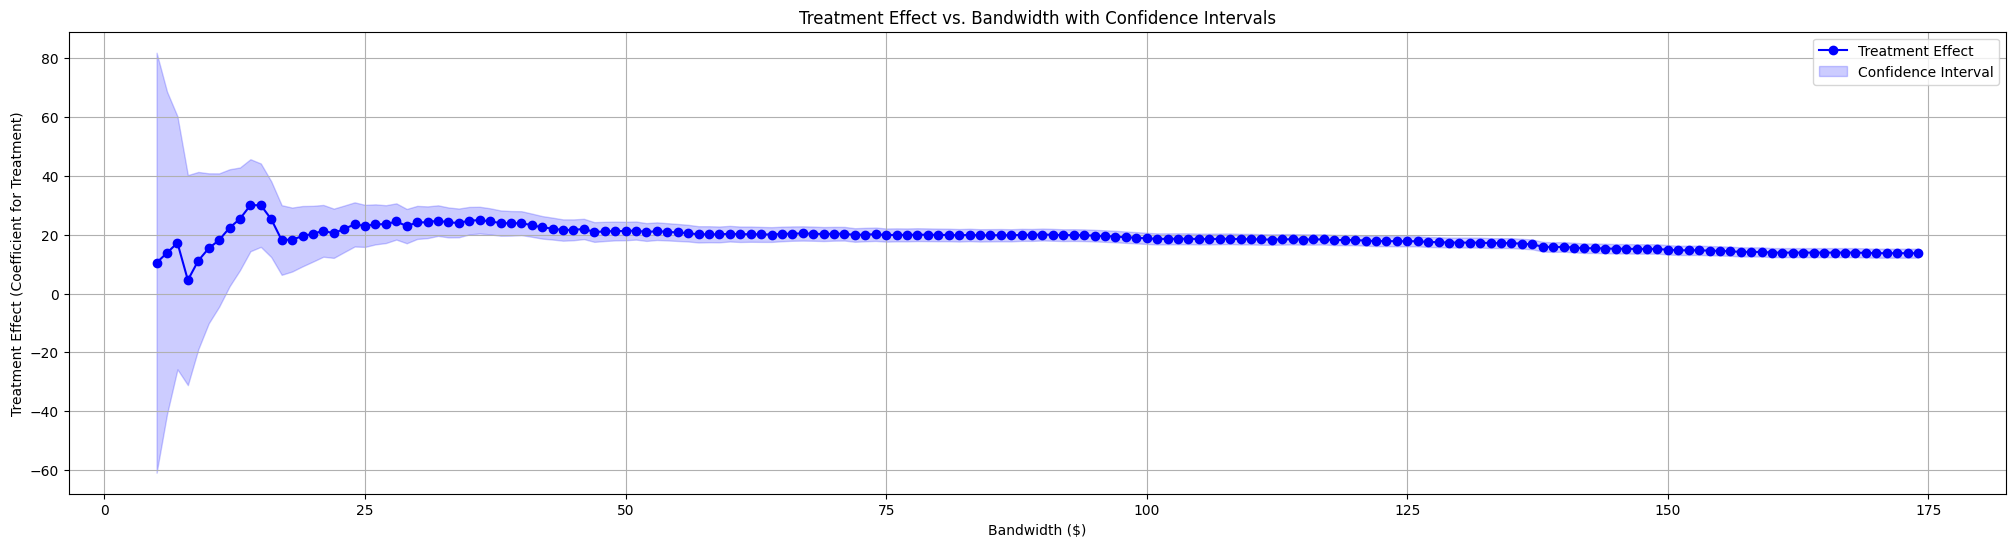

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Plotting the treatment effect vs. bandwidth, complete range of data colected ($5 - $200)
plt.figure(figsize=(25, 6))
plt.plot(results_df['Bandwidth'], results_df['Treatment_Effect'], label='Treatment Effect', marker='o', color='b')
plt.fill_between(results_df['Bandwidth'], results_df['CI_Lower'], results_df['CI_Upper'], color='b', alpha=0.2, label='Confidence Interval')
plt.xlabel('Bandwidth ($)')
plt.ylabel('Treatment Effect (Coefficient for Treatment)')
plt.title('Treatment Effect vs. Bandwidth with Confidence Intervals')
plt.legend()
plt.grid(True)
plt.show()

###Main Takeaways:
*   

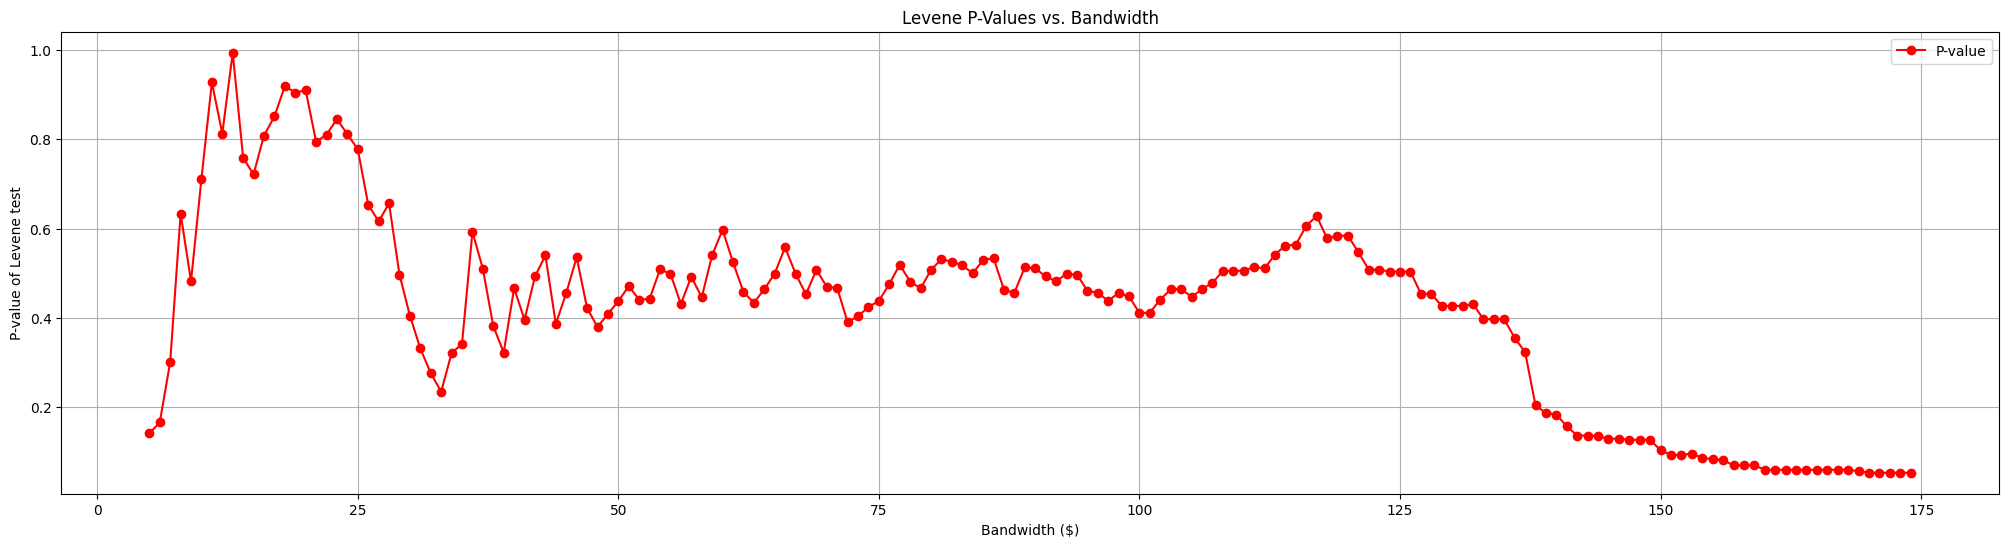

In [ ]:
# Plotting the p-value of Levene tests vs. the bandwidth
plt.figure(figsize=(25, 6))
plt.plot(results_df['Bandwidth'], results_df['Levene_P-Values'], label='P-value', marker='o', color='r')
plt.xlabel('Bandwidth ($)')
plt.ylabel('P-value of Levene test')
plt.title('Levene P-Values vs. Bandwidth')
plt.legend()
plt.grid(True)
plt.show()

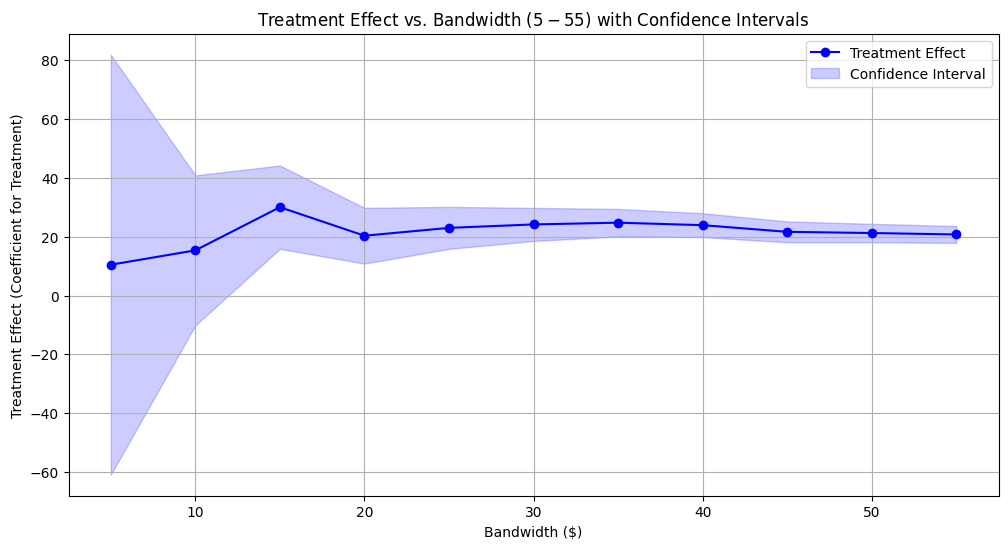

In [ ]:
# Slice the existing DataFrame to focus on the smaller range ($5 to $55)
start = 5
end = 55
inc = 5

partial_results_df = results_df[(results_df['Bandwidth'] >= start) & (results_df['Bandwidth'] <= end)]
partial_results_df = partial_results_df[partial_results_df['Bandwidth'] % inc == 0]

# Plotting the treatment effect vs. bandwidth, partial range of data colected ($5 - $55)
plt.figure(figsize=(12, 6))
plt.plot(partial_results_df['Bandwidth'], partial_results_df['Treatment_Effect'], label='Treatment Effect', marker='o', color='b')
plt.fill_between(partial_results_df['Bandwidth'], partial_results_df['CI_Lower'], partial_results_df['CI_Upper'], color='b', alpha=0.2, label='Confidence Interval')
plt.xlabel('Bandwidth ($)')
plt.ylabel('Treatment Effect (Coefficient for Treatment)')
plt.title('Treatment Effect vs. Bandwidth ($5 - $55) with Confidence Intervals')
plt.legend()
plt.grid(True)
plt.show()

###Main Takeaways:
*   As the bandwidth increases from 5 to 50, the treatment effect stabilizes. In the smaller bandwidth ranges (5-20), there is more variation, but after around 20-25, the treatment effect seems to stabilize around 20.

*   The confidence intervals are very wide at smaller bandwidths. This suggests a high degree of uncertainty about the treatment effect when considering smaller ranges of data around the threshold. As the bandwidth increases, the confidence intervals become narrower, reflecting greater certainty in the estimated treatment effect.
  *   This might indicate that with such a small sample near the treatment threshold, the model struggles to estimate the treatment effect accurately.
  *   Beyond a certain bandwidth (20-25), the treatment effect estimate becomes consistent, suggesting that this may be an appropriate bandwidth to use when estimating the treatment effect.

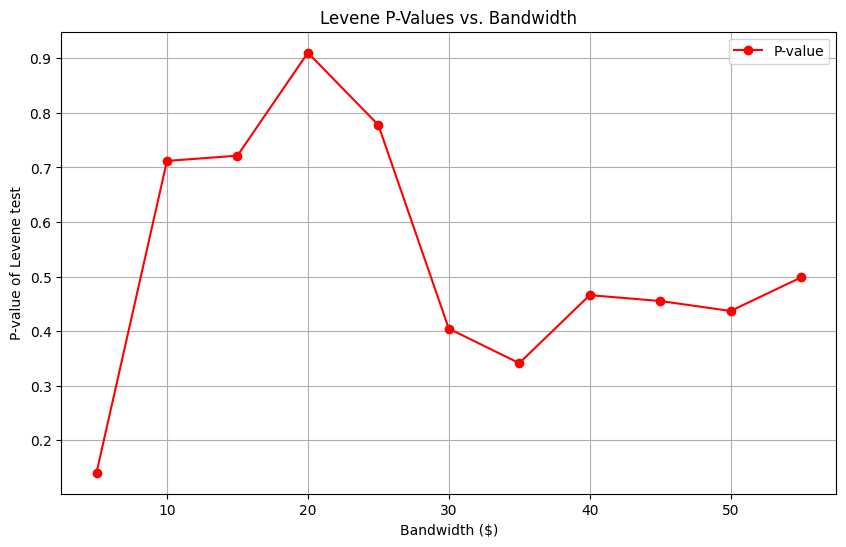

In [ ]:
# Plotting the p-value of Levene tests vs. the bandwidth
plt.figure(figsize=(10, 6))
plt.plot(partial_results_df['Bandwidth'], partial_results_df['Levene_P-Values'], label='P-value', marker='o', color='r')
plt.xlabel('Bandwidth ($)')
plt.ylabel('P-value of Levene test')
plt.title('Levene P-Values vs. Bandwidth')
plt.legend()
plt.grid(True)
plt.show()

###Main Takeaways:
*   The p-values are generally high between bandwidths 15 to 25, peaking around bandwidth 20.
  *   Indicating that there is no significant difference in the variance between the treated and untreated groups

*   The p-values drop below 0.05 at bandwidth 30, which suggests unequal variances in the residuals


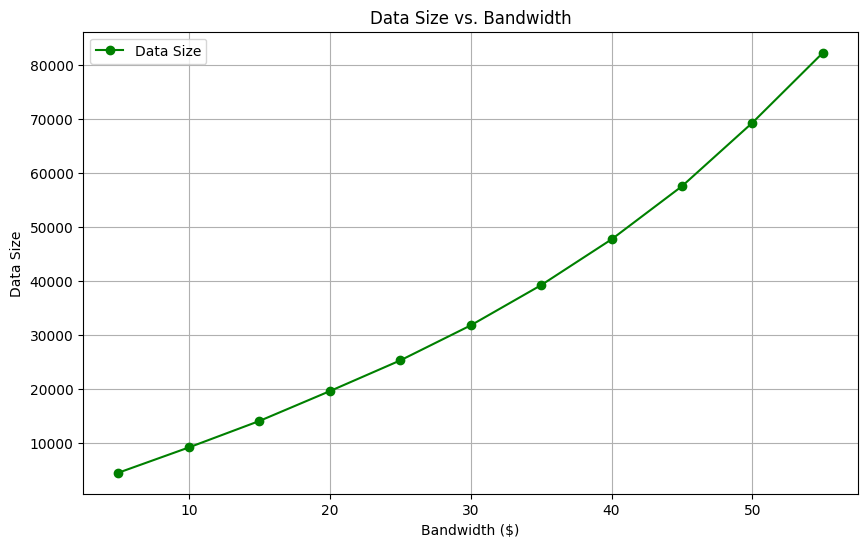

In [ ]:
# Plotting the p-value of Levene tests vs. the bandwidth
plt.figure(figsize=(10, 6))
plt.plot(partial_results_df['Bandwidth'], partial_results_df['Data_Size'], label='Data Size', marker='o', color='g')
plt.xlabel('Bandwidth ($)')
plt.ylabel('Data Size')
plt.title('Data Size vs. Bandwidth')
plt.legend()
plt.grid(True)
plt.show()

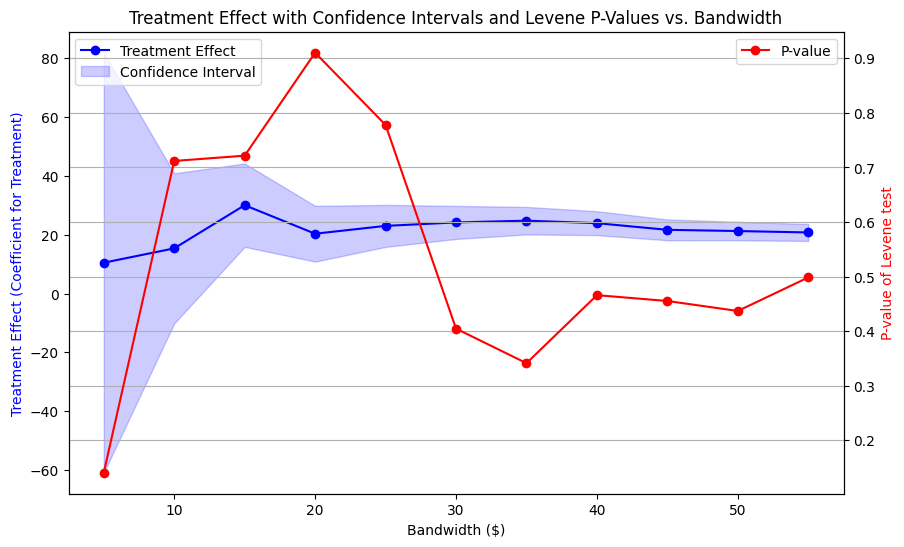

In [ ]:
# Plotting the treatment effect & p-value of Levene tests vs. bandwidth

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel('Bandwidth ($)')

# Plotting treatment effect with CI intervals on the left y-axis
ax1.set_ylabel('Treatment Effect (Coefficient for Treatment)', color='b')
ax1.plot(partial_results_df['Bandwidth'], partial_results_df['Treatment_Effect'], label='Treatment Effect', marker='o', color='b')
ax1.fill_between(partial_results_df['Bandwidth'], partial_results_df['CI_Lower'], partial_results_df['CI_Upper'], color='b', alpha=0.2, label='Confidence Interval')
plt.legend(loc='upper left')

# Plotting the p-value of Levene tests on the right y-axis
ax2 = ax1.twinx()
ax2.set_ylabel('P-value of Levene test', color='r')
ax2.plot(partial_results_df['Bandwidth'], partial_results_df['Levene_P-Values'], label='P-value', marker='o', color='r')
plt.legend()

plt.title('Treatment Effect with Confidence Intervals and Levene P-Values vs. Bandwidth')
plt.grid(True)
plt.show()

###Main Takeaways:
*   Based on the combination of treatment effect stability and high p-values from Levene's test, the 15-25 bandwidth range appears to be the most reliable for estimating the treatment effect.

*   Avoid Smaller and Larger Bandwidths: At very small bandwidths, the treatment effect estimate is highly variable, and the confidence intervals are wide, indicating high uncertainty. For bandwidths larger than 30, the presence of heteroscedasticity (low Levene p-values) makes the estimates less trustworthy.


# *Additional Bandwidth Analysis*
Seeking sharp changes or a significant shift in the effect to identify points of inflection.

### Treatment Effect Cumulative Sum Plot

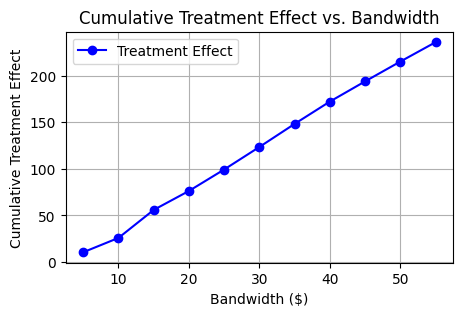

In [ ]:
# Plotting the cumulative sum of the treatment effect
plt.figure(figsize=(5, 3))
plt.plot(partial_results_df['Bandwidth'], partial_results_df['Treatment_Effect'].cumsum(), label='Treatment Effect', marker='o', color='b')
plt.xlabel('Bandwidth ($)')
plt.ylabel('Cumulative Treatment Effect')
plt.title('Cumulative Treatment Effect vs. Bandwidth')
plt.legend()
plt.grid(True)
plt.show()

### Treatment Effect Rate of Change Plot

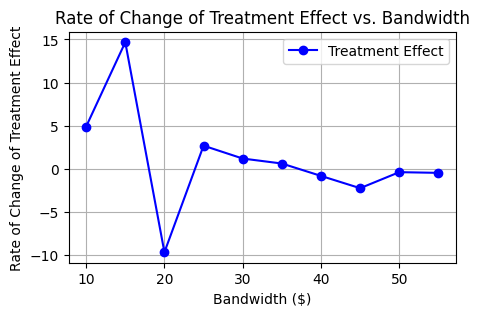

In [ ]:
# Calculate the rate of change (derivative) of the treatment effect
plt.figure(figsize=(5, 3))
plt.plot(partial_results_df['Bandwidth'], partial_results_df['Treatment_Effect'].diff(), label='Treatment Effect', marker='o', color='b')
plt.xlabel('Bandwidth ($)')
plt.ylabel('Rate of Change of Treatment Effect')
plt.title('Rate of Change of Treatment Effect vs. Bandwidth')
plt.legend()
plt.grid(True)
plt.show()


The plot reveals a point where the treatment effect changes rapidly, indicating an inflection point where the bandwidth starts to stabilize.

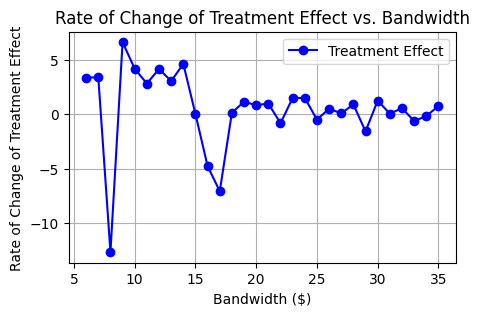

In [27]:
# Closer look at where the rate of change stabalizes
ROC_results_df = results_df[(results_df['Bandwidth'] >= 5) & (results_df['Bandwidth'] <= 35)]

plt.figure(figsize=(5, 3))
plt.plot(ROC_results_df['Bandwidth'], ROC_results_df['Treatment_Effect'].diff(), label='Treatment Effect', marker='o', color='b')
plt.xlabel('Bandwidth ($)')
plt.ylabel('Rate of Change of Treatment Effect')
plt.title('Rate of Change of Treatment Effect vs. Bandwidth')
plt.legend()
plt.grid(True)
plt.show()

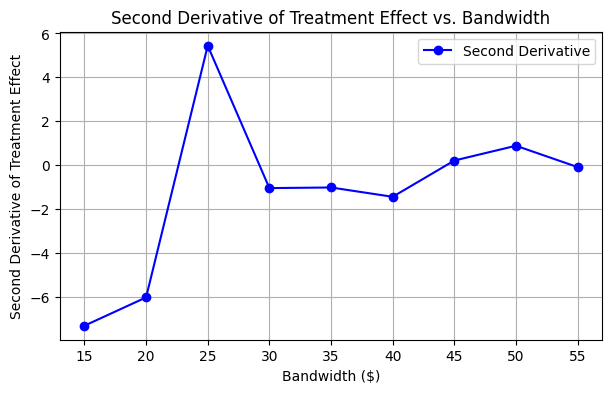

In [33]:
# Calculate second derivative (rate of change of the rate of change)
treatment_effect_second_derivative = np.gradient(partial_results_df['Treatment_Effect'].diff())

# Plot the second derivative
plt.figure(figsize=(7, 4))
plt.plot(partial_results_df['Bandwidth'], treatment_effect_second_derivative, label='Second Derivative', marker='o', color='b')
plt.xlabel('Bandwidth ($)')
plt.ylabel('Second Derivative of Treatment Effect')
plt.title('Second Derivative of Treatment Effect vs. Bandwidth')
plt.legend()
plt.grid(True)
plt.show()